# (-24,0) to predict BSI positive VS negative and baseline 


In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import scipy
from matplotlib import colors

import FAIRStream

## Data Engineering

In [2]:
# csv pool folder directory
csv_pool_path = '/Users/jiaxingqiu/Documents/CAMA_projects/BSI/code/projects/csv_pool'
# current experiment working directory
work_dir = '/Users/jiaxingqiu/Documents/CAMA_projects/BSI/code/projects/case_txp'

In [3]:
# initiate a FAIRStream object instance for BSI project
bsi_stream = FAIRStream.FAIRStream(work_dir)
# take a look at dictionaries in engineer's hands
#bsi_stream.engineer.csv_source_dict
bsi_stream.engineer.variable_dict

Success: Querier has initiated a csv source dictionary in:/Users/jiaxingqiu/Documents/CAMA_projects/BSI/code/projects/case_txp/meta_data/csv_source_dict_demo.json
Success: Querier has initiated a variable dictionary in:/Users/jiaxingqiu/Documents/CAMA_projects/BSI/code/projects/case_txp/meta_data/variable_dict_demo.json
Unable to read sql source dictionary. Use Querier.update_sql_source_dict() to build one.


{'__uid': {'src_names': ['id', 'ID', 'subject_id', 'subject_id'],
  'label': 'unique subject id for current study',
  'unique_per_sbj': True},
 '__time': {'src_names': ['tsa', 'tsa', 'timeMinutes', 'timeMinutes'],
  'label': 'time since admission',
  'unit': 'minute'},
 '__anchor': {'src_names': ['True_positive', 'True positive'],
  'label': 'anchor for an episode',
  'unique_per_sbj': False,
  'factor': {'levels': {'__neg_nbc': ['0', '0.0', 'nan'],
    '__pos': ['1', '1.0']},
   'impute_per_sbj': {'nan_level': '__neg_nbc'}}},
 'y': {'output': True,
  'src_names': ['True_positive', 'True positive'],
  'label': 'Event outcome result',
  'unique_per_sbj': False,
  'factor': {'levels': {'nbc': ['nan'],
    'neg': ['0', '0.0'],
    'pos': ['1', '1.0']},
   'impute_per_sbj': {'nan_level': 'nbc'}}},
 'txp': {'input': True,
  'src_names': ['Confirmed Txp'],
  'label': 'Transplant recipient',
  'unique_per_sbj': True,
  'factor': {'levels': {'no': ['0', '0.0', 'nan'], 'yes': ['1', '1.0']},
   

In [4]:
# define an episode (notice that the engineer now has new attributes)
bsi_stream.engineer.DefineEpisode(input_time_len=2*24*60, # using vital signs and labs 4 days prior to a culture 
                                  output_time_len=24*60, # predict one time unit into the future
                                  time_resolution=60, # aggregate minutely data to one row per hour 
                                  time_lag=0,  # no time lag between predictors and response
                                  anchor_gap=7*24*60) # the minimum distance between two episodes

 
Success! An episode is defined to 
--- use 2880 minute(s) long input variables 
--- predict 1440 minute(s) response variables into the future
--- lag 0 minute(s) between predictors and responses
--- increase by every 60 minute(s)
--- last at most 10080 minute(s) long
Success! Engineer has updated attributes --- episode. 


In [5]:
# Build MVTS dataframe or tfds  (notice that the engineer now has new attributes)
bsi_stream.engineer.BuildMVTS(csv_pool_path, 
                              #nsbj = 6000, # number of subjects / patients to sample from the pool 
                              nsbj = 60, # number of subjects / patients to sample from the pool 
                              replace=True, # sample with replacement or not 
                              valid_frac = 0.2, # fraction of number of subjects in validation dataset
                              test_frac = 0, # fraction of number of subjects in left-out test dataset
                              batch_size = 64, # batch size (usually 32,64,128..)
                              impute_input='median', # imputation on predictors
                              impute_output='median' )# imputation on response (no need in BSI project)

# please see the end of console 
# # --- Success! Engineer has updated attributes --- train_df_imputed, valid_df_imputed and test_df_imputed. 
# # --- Success! Engineer has updated attributes --- train_tfds, valid_tfds and test_tfds. 

Engineer is sampling with replacement --- 
Success!  60 out of 5671 subjects are sampled from csv pool of size 26093 !
--- fix upper boundary for age by nan
--- fix lower boundary for age by nan
--- fix upper boundary for temp by nan
--- fix lower boundary for temp by nan
--- fix upper boundary for heart_rate by nan
--- fix lower boundary for heart_rate by nan
--- fix upper boundary for resp_rate by nan
--- fix lower boundary for resp_rate by nan
--- fix upper boundary for spo2 by nan
--- fix lower boundary for spo2 by nan
--- fix upper boundary for x_hr_rr by nan
--- fix lower boundary for x_hr_rr by nan
--- fix upper boundary for s_hr by nan
--- fix lower boundary for s_hr by nan
--- fix upper boundary for s_rr by nan
--- fix lower boundary for s_rr by nan
--- fix upper boundary for s_so2 by nan
--- fix lower boundary for s_so2 by nan
--- fix upper boundary for systolic_blood_pressure by nan
--- fix lower boundary for systolic_blood_pressure by nan
--- fix upper boundary for diastoli

Success! Output/responce variable mean in current sample space  --- 
y___neg    0.769231
y___pos    0.102564
y___nbc    0.128205
dtype: float64
--- prepare episodes for uva_291
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.775
y___pos    0.100
y___nbc    0.125
dtype: float64
--- prepare episodes for uva_2531
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.780488
y___pos    0.097561
y___nbc    0.121951
dtype: float64
--- prepare episodes for uva_8255
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.785714
y___pos    0.095238
y___nbc    0.119048
dtype: float64
--- prepare episodes for uva_7943
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.772727
y___pos    0.090909
y___nbc    0.136364
dtype: float64
--- prepare episodes for uva_7605
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.777778
y___pos    0.088889
y___nbc    

In [6]:
bsi_stream.engineer.info()


----------------------------- Engineer Attributes List ------------------------

['work_dir', 'meta_dir', 'variable_dict', 'csv_source_dict', 'sql_source_dict', 'input_vars', 'output_vars', 'episode', 'sample_info', 'mvts_df', 'mvts_tfds', 'train_df', 'valid_df', 'test_df', 'train_df_imputed', 'valid_df_imputed', 'test_df_imputed', 'train_tfds', 'valid_tfds', 'test_tfds', 'df_csv_fullname_ls']

------------------------------------- Inputs  --------------------------------- 

['txp___yes', 'txp___no', 'age___vital', 'temp___vital', 'heart_rate___vital', 'resp_rate___vital', 'spo2___vital', 'x_hr_rr___vital', 's_hr___vital', 's_rr___vital', 's_so2___vital', 'systolic_blood_pressure___vital', 'diastolic_blood_pressure___vital', 'glucose___vital', 'bilirubin___vital', 'potassium___vital', 'albumin___vital', 'calcium___vital', 'sodium___vital', 'wbc___vital', 'phosphorus___vital', 'creatinine___vital', 'platelet_count___vital', 'alt___vital', 'alp___vital', 'ast___vital', 'pco2___vital', '

In [7]:
# # save raw dataframe in a csv
# bsi_stream.engineer.train_df.to_csv("./train_df.csv", index=False)
# bsi_stream.engineer.valid_df.to_csv("./valid_df.csv", index=False)
# bsi_stream.engineer.train_df_imputed.to_csv("./train_df_median.csv", index=False)
# bsi_stream.engineer.valid_df_imputed.to_csv("./valid_df_median.csv", index=False)

## Modeling -- Binary classification

In [45]:
# read datasets
train_df = pd.read_csv("./train_df.csv")
valid_df = pd.read_csv("./valid_df.csv")

# select modeling time window
train_df = train_df.loc[(train_df['__ep_relative_time']/60>=-24) & (train_df['__ep_relative_time']/60<=0) ,:]
valid_df = valid_df.loc[(valid_df['__ep_relative_time']/60>=-24) & (valid_df['__ep_relative_time']/60<=0) ,:]

# median imputation
train_df.fillna(train_df.median(), inplace=True)
valid_df.fillna(train_df.median(), inplace=True)

# input and output variable name lists
input_vars = ['txp___yes', 'age___vital', 'temp___vital', 'heart_rate___vital', 'resp_rate___vital', 'spo2___vital', 'x_hr_rr___vital', 's_hr___vital', 's_rr___vital', 's_so2___vital', 'systolic_blood_pressure___vital', 'diastolic_blood_pressure___vital', 'glucose___vital', 'bilirubin___vital', 'potassium___vital', 'albumin___vital', 'calcium___vital', 'sodium___vital', 'wbc___vital', 'phosphorus___vital', 'creatinine___vital', 'platelet_count___vital', 'alt___vital', 'alp___vital', 'ast___vital', 'pco2___vital', 'chloride___vital', 'troponin___vital', 'ptt___vital', 'lactate___vital', 'bun___vital', 'magnesium___vital']
output_var = ['y___pos']

# # standardize inputs
# train_df[input_vars] = (train_df[input_vars] - train_df[input_vars].mean(axis=0))/train_df[input_vars].std(axis=0)
# valid_df[input_vars] = (valid_df[input_vars] - train_df[input_vars].mean(axis=0))/train_df[input_vars].std(axis=0)

# combine to one dataframe
whole_df = pd.concat([train_df, valid_df], axis=0)
whole_df.describe()

,txp___yes,txp___no,age___vital,temp___vital,heart_rate___vital,resp_rate___vital,spo2___vital,x_hr_rr___vital,s_hr___vital,s_rr___vital,...,ptt___vital,lactate___vital,bun___vital,magnesium___vital,y___pos,y___neg,y___nbc,__time_bin,__ep_relative_time,__ep_order
count,163925.000000,163925.000000,163925.000000,163925.000000,163925.000000,163925.000000,163925.000000,163925.000000,163925.000000,163925.000000,...,163925.000000,163925.000000,163925.000000,163925.000000,163925.000000,163925.000000,163925.000000,163925.000000,163925.000000,163925.000000
mean,0.031569,0.959280,59.053610,98.130162,92.198995,22.233793,97.465885,0.200550,3.772581,4.182335,...,31.718885,2.142800,28.747296,1.894027,0.133750,0.658685,0.207564,73.844136,-720.000000,1.208327
std,0.174851,0.197641,16.534095,1.284749,9.032714,3.062896,1.312926,0.087419,1.484878,1.399994,...,9.304526,1.845225,22.660112,0.340634,0.340385,0.474152,0.405564,444.434054,432.667473,0.672273
min,0.000000,0.000000,14.101500,60.800000,39.448590,5.735512,80.141327,-0.630122,0.000000,0.000000,...,19.200000,0.200000,2.000000,0.600000,0.000000,0.000000,0.000000,-4235.000000,-1440.000000,1.000000
25%,0.000000,1.000000,49.424096,98.100000,91.940753,22.072590,97.606914,0.195842,3.616698,4.083966,...,27.700000,1.600000,15.000000,1.800000,0.000000,0.000000,0.000000,-15.000000,-1080.000000,1.000000
50%,0.000000,1.000000,60.267953,98.100000,91.940753,22.072590,97.606914,0.195842,3.616698,4.083966,...,29.700000,1.700000,22.000000,1.900000,0.000000,1.000000,0.000000,-7.000000,-720.000000,1.000000
75%,0.000000,1.000000,71.116943,98.100000,91.940753,22.072590,97.606914,0.195842,3.616698,4.083966,...,32.000000,1.900000,34.000000,2.000000,0.000000,1.000000,0.000000,0.000000,-360.000000,1.000000
max,1.000000,1.000000,90.000000,105.100000,168.179487,70.228390,100.000000,0.928040,47.721125,17.975902,...,136.000000,34.200000,246.000000,7.900000,1.000000,1.000000,1.000000,16454.000000,0.000000,14.000000


In [46]:
# reformat inputs to be 2d image and 1 output per image
X_whole = whole_df[input_vars].values
Y_whole = whole_df[output_var].values
X_whole = np.reshape(X_whole, (-1,25,32) )
Y_whole = np.reshape(Y_whole, (-1,25,1) )[:,0,:]
print(X_whole.shape)
print(Y_whole.shape)

# reformat inputs to be 2d image and 1 output per image
X_train = train_df[input_vars].values
Y_train = train_df[output_var].values
X_train = np.reshape(X_train, (-1,25,32) )
Y_train = np.reshape(Y_train, (-1,25,1) )[:,0,:]
print(X_train.shape)
print(Y_train.shape)

# reformat inputs to be 2d image and 1 output per image
X_valid = valid_df[input_vars].values
Y_valid = valid_df[output_var].values
X_valid = np.reshape(X_valid, (-1,25,32) )
Y_valid = np.reshape(Y_valid, (-1,25,1) )[:,0,:]
print(X_valid.shape)
print(Y_valid.shape)


(6557, 25, 32)
(6557, 1)
(5226, 25, 32)
(5226, 1)
(1331, 25, 32)
(1331, 1)


### Logistic Regression

In [51]:
myMetrics = [
    keras.metrics.AUC(name='AUROC', curve='ROC'),
    keras.metrics.AUC(name='AUPRC', curve='PR')
]

keras.backend.clear_session()
mdl = keras.models.Sequential([
    keras.layers.Flatten(input_shape=list(X_train.shape)[1:4]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(1, activation='sigmoid')
])
mdl.summary()
mdl.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=1e-3), metrics = myMetrics)
callback = EarlyStopping(monitor='val_loss', patience=10)
his = mdl.fit(X_train, Y_train, 
              epochs=50, 
              validation_data=(X_valid,Y_valid), callbacks=[callback])
keras.backend.set_value(mdl.optimizer.learning_rate, 1e-4)
his = mdl.fit(X_train, Y_train, 
              epochs=50, 
              validation_data=(X_valid,Y_valid), callbacks=[callback])
keras.backend.set_value(mdl.optimizer.learning_rate, 1e-5)
his = mdl.fit(X_train, Y_train, 
              epochs=50, 
              validation_data=(X_valid,Y_valid), callbacks=[callback])
keras.backend.set_value(mdl.optimizer.learning_rate, 1e-6)
his = mdl.fit(X_train, Y_train, 
              epochs=50, 
              validation_data=(X_valid,Y_valid), callbacks=[callback])
keras.backend.set_value(mdl.optimizer.learning_rate, 1e-7)
his = mdl.fit(X_train, Y_train, 
              epochs=50, 
              validation_data=(X_valid,Y_valid), callbacks=[callback])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 800)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 800)               3200      
_________________________________________________________________
dense (Dense)                (None, 1)                 801       
Total params: 4,001
Trainable params: 2,401
Non-trainable params: 1,600
_________________________________________________________________
Epoch 1/50
164/164 [==============================] - 1s 3ms/step - loss: 0.5155 - AUROC: 0.6206 - AUPRC: 0.2190 - val_loss: 4.0327 - val_AUROC: 0.6906 - val_AUPRC: 0.2402
Epoch 2/50
164/164 [==============================] - 0s 1ms/step - loss: 0.3186 - AUROC: 0.7947 - AUPRC: 0.4381 - val_loss: 0.3889 - val_AUROC: 0.7458 - val_AUPRC: 0.3872
Epoch 3/50
164/164 [================

164/164 [==============================] - 0s 1ms/step - loss: 0.2754 - AUROC: 0.8589 - AUPRC: 0.5693 - val_loss: 0.3528 - val_AUROC: 0.7792 - val_AUPRC: 0.4367
Epoch 15/50
164/164 [==============================] - 0s 1ms/step - loss: 0.2811 - AUROC: 0.8543 - AUPRC: 0.5467 - val_loss: 0.3490 - val_AUROC: 0.7788 - val_AUPRC: 0.4420
Epoch 16/50
164/164 [==============================] - 0s 1ms/step - loss: 0.2786 - AUROC: 0.8575 - AUPRC: 0.5548 - val_loss: 0.3480 - val_AUROC: 0.7799 - val_AUPRC: 0.4453
Epoch 1/50
164/164 [==============================] - 0s 1ms/step - loss: 0.2757 - AUROC: 0.8598 - AUPRC: 0.5697 - val_loss: 0.3491 - val_AUROC: 0.7805 - val_AUPRC: 0.4428
Epoch 2/50
164/164 [==============================] - 0s 1ms/step - loss: 0.2726 - AUROC: 0.8577 - AUPRC: 0.5833 - val_loss: 0.3479 - val_AUROC: 0.7797 - val_AUPRC: 0.4439
Epoch 3/50
164/164 [==============================] - 0s 1ms/step - loss: 0.2758 - AUROC: 0.8566 - AUPRC: 0.5718 - val_loss: 0.3490 - val_AUROC: 0.78

### LSTM

In [52]:
myMetrics = [
    keras.metrics.AUC(name='AUROC', curve='ROC'),
    keras.metrics.AUC(name='AUPRC', curve='PR')
]

keras.backend.clear_session()
mdl = keras.models.Sequential([
    keras.layers.LSTM(16, return_sequences=True, input_shape=list(X_train.shape)[1:4]),
    keras.layers.BatchNormalization(),
    keras.layers.LSTM(16, return_sequences=False),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(1, activation='sigmoid')
])
mdl.summary()
mdl.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=1e-3), metrics = myMetrics)
callback = EarlyStopping(monitor='val_loss', patience=10)
his = mdl.fit(X_train, Y_train, 
              epochs=50, 
              validation_data=(X_valid,Y_valid), callbacks=[callback])
keras.backend.set_value(mdl.optimizer.learning_rate, 1e-4)
his = mdl.fit(X_train, Y_train, 
              epochs=50, 
              validation_data=(X_valid,Y_valid), callbacks=[callback])
keras.backend.set_value(mdl.optimizer.learning_rate, 1e-5)
his = mdl.fit(X_train, Y_train, 
              epochs=50, 
              validation_data=(X_valid,Y_valid), callbacks=[callback])
keras.backend.set_value(mdl.optimizer.learning_rate, 1e-6)
his = mdl.fit(X_train, Y_train, 
              epochs=50, 
              validation_data=(X_valid,Y_valid), callbacks=[callback])
keras.backend.set_value(mdl.optimizer.learning_rate, 1e-7)
his = mdl.fit(X_train, Y_train, 
              epochs=50, 
              validation_data=(X_valid,Y_valid), callbacks=[callback])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 25, 16)            3136      
_________________________________________________________________
batch_normalization (BatchNo (None, 25, 16)            64        
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                2112      
_________________________________________________________________
batch_normalization_1 (Batch (None, 16)                64        
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 5,393
Trainable params: 5,329
Non-trainable params: 64
_________________________________________________________________
Epoch 1/50
164/164 [==============================] - 6s 18ms/step - loss: 0.7291 - AUROC: 0.5428 - AUPRC: 0.1343 - val

164/164 [==============================] - 2s 14ms/step - loss: 0.3356 - AUROC: 0.7471 - AUPRC: 0.3551 - val_loss: 0.3524 - val_AUROC: 0.7481 - val_AUPRC: 0.3517
Epoch 6/50
164/164 [==============================] - 2s 15ms/step - loss: 0.3348 - AUROC: 0.7518 - AUPRC: 0.3587 - val_loss: 0.3514 - val_AUROC: 0.7477 - val_AUPRC: 0.3517
Epoch 7/50
164/164 [==============================] - 2s 15ms/step - loss: 0.3355 - AUROC: 0.7436 - AUPRC: 0.3659 - val_loss: 0.3523 - val_AUROC: 0.7497 - val_AUPRC: 0.3582
Epoch 8/50
164/164 [==============================] - 2s 14ms/step - loss: 0.3319 - AUROC: 0.7568 - AUPRC: 0.3800 - val_loss: 0.3514 - val_AUROC: 0.7459 - val_AUPRC: 0.3606
Epoch 9/50
164/164 [==============================] - 2s 15ms/step - loss: 0.3325 - AUROC: 0.7513 - AUPRC: 0.3706 - val_loss: 0.3517 - val_AUROC: 0.7521 - val_AUPRC: 0.3615
Epoch 10/50
164/164 [==============================] - 2s 14ms/step - loss: 0.3325 - AUROC: 0.7511 - AUPRC: 0.3555 - val_loss: 0.3496 - val_AUROC:

164/164 [==============================] - 2s 15ms/step - loss: 0.3260 - AUROC: 0.7690 - AUPRC: 0.3829 - val_loss: 0.3497 - val_AUROC: 0.7564 - val_AUPRC: 0.3666
Epoch 7/50
164/164 [==============================] - 2s 15ms/step - loss: 0.3241 - AUROC: 0.7739 - AUPRC: 0.3956 - val_loss: 0.3498 - val_AUROC: 0.7567 - val_AUPRC: 0.3646
Epoch 8/50
164/164 [==============================] - 3s 15ms/step - loss: 0.3224 - AUROC: 0.7739 - AUPRC: 0.3979 - val_loss: 0.3497 - val_AUROC: 0.7571 - val_AUPRC: 0.3659
Epoch 9/50
164/164 [==============================] - 3s 17ms/step - loss: 0.3263 - AUROC: 0.7674 - AUPRC: 0.3846 - val_loss: 0.3495 - val_AUROC: 0.7572 - val_AUPRC: 0.3680
Epoch 10/50
164/164 [==============================] - 3s 18ms/step - loss: 0.3248 - AUROC: 0.7718 - AUPRC: 0.3929 - val_loss: 0.3499 - val_AUROC: 0.7565 - val_AUPRC: 0.3655
Epoch 11/50
164/164 [==============================] - 3s 18ms/step - loss: 0.3271 - AUROC: 0.7627 - AUPRC: 0.3870 - val_loss: 0.3497 - val_AUROC

164/164 [==============================] - 3s 18ms/step - loss: 0.3240 - AUROC: 0.7719 - AUPRC: 0.3864 - val_loss: 0.3493 - val_AUROC: 0.7558 - val_AUPRC: 0.3671
Epoch 20/50
164/164 [==============================] - 3s 21ms/step - loss: 0.3240 - AUROC: 0.7671 - AUPRC: 0.3968 - val_loss: 0.3492 - val_AUROC: 0.7567 - val_AUPRC: 0.3670
Epoch 21/50
164/164 [==============================] - 3s 20ms/step - loss: 0.3247 - AUROC: 0.7682 - AUPRC: 0.3943 - val_loss: 0.3493 - val_AUROC: 0.7565 - val_AUPRC: 0.3674
Epoch 22/50
164/164 [==============================] - 3s 19ms/step - loss: 0.3256 - AUROC: 0.7678 - AUPRC: 0.3833 - val_loss: 0.3494 - val_AUROC: 0.7569 - val_AUPRC: 0.3682
Epoch 23/50
164/164 [==============================] - 3s 19ms/step - loss: 0.3260 - AUROC: 0.7672 - AUPRC: 0.3895 - val_loss: 0.3495 - val_AUROC: 0.7567 - val_AUPRC: 0.3654
Epoch 24/50
164/164 [==============================] - 3s 19ms/step - loss: 0.3225 - AUROC: 0.7736 - AUPRC: 0.4026 - val_loss: 0.3493 - val_AU

# Multi-class classification

In [14]:
train_df = pd.read_csv("./train_df.csv")
valid_df = pd.read_csv("./valid_df.csv")
whole_df = pd.concat([train_df, valid_df], axis=0)

# median imputation
train_df.fillna(whole_df.median(), inplace=True)
valid_df.fillna(whole_df.median(), inplace=True)
whole_df.fillna(whole_df.median(), inplace=True)


In [17]:
input_vars = ['txp___yes', 'age___vital', 'temp___vital', 'heart_rate___vital', 'resp_rate___vital', 'spo2___vital', 'x_hr_rr___vital', 's_hr___vital', 's_rr___vital', 's_so2___vital', 'systolic_blood_pressure___vital', 'diastolic_blood_pressure___vital', 'glucose___vital', 'bilirubin___vital', 'potassium___vital', 'albumin___vital', 'calcium___vital', 'sodium___vital', 'wbc___vital', 'phosphorus___vital', 'creatinine___vital', 'platelet_count___vital', 'alt___vital', 'alp___vital', 'ast___vital', 'pco2___vital', 'chloride___vital', 'troponin___vital', 'ptt___vital', 'lactate___vital', 'bun___vital', 'magnesium___vital']
output_var = ['y___pos','y___neg','y___nbc']

# reformat inputs to be 2d image and 1 output per image
X_train = train_df[input_vars].values
Y_train = train_df[output_var].values
X_train = np.reshape(X_train, (-1,72,32) )
Y_train = np.reshape(Y_train, (-1,72,3) )[:,0,:]
#X_train = (X_train - X_train.mean(axis=0))/X_train.std(axis=0)

print(X_train.shape)
print(Y_train.shape)

# reformat inputs to be 2d image and 1 output per image
X_valid = valid_df[input_vars].values
Y_valid = valid_df[output_var].values
X_valid = np.reshape(X_valid, (-1,72,32) )
Y_valid = np.reshape(Y_valid, (-1,72,3) )[:,0,:]
#X_valid = (X_valid - X_train.mean(axis=0))/X_train.std(axis=0)
print(X_valid.shape)
print(Y_valid.shape)

# reformat inputs to be 2d image and 1 output per image
X_whole = whole_df[input_vars].values
Y_whole = whole_df[output_var].values
X_whole = np.reshape(X_whole, (-1,72,32) )
Y_whole = np.reshape(Y_whole, (-1,72,3) )[:,0,:]
#X_whole = (X_whole - X_train.mean(axis=0))/X_train.std(axis=0)
print(X_whole.shape)
print(Y_whole.shape)


(5226, 72, 32)
(5226, 3)
(1331, 72, 32)
(1331, 3)
(6557, 72, 32)
(6557, 3)


In [19]:
myMetrics = [
    keras.metrics.AUC(name='AUROC', curve='ROC', multi_label=True),
    keras.metrics.AUC(name='AUPRC', curve='PR', multi_label=True)
]

keras.backend.clear_session()
mdl = keras.models.Sequential([
    keras.layers.LSTM(72, return_sequences=True, input_shape=list(X_train.shape)[1:4]),
    keras.layers.BatchNormalization(),
#     keras.layers.LSTM(64, return_sequences=True),
#     keras.layers.BatchNormalization(),
#     keras.layers.SimpleRNN(64, return_sequences=True),
#     keras.layers.BatchNormalization(),
    keras.layers.SimpleRNN(32, return_sequences=False),
    keras.layers.BatchNormalization(),
    keras.layers.Flatten(),
    keras.layers.Dense(16, activation='sigmoid'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(16, activation='sigmoid'),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(3, activation='softmax')
])
mdl.summary()
mdl.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=1e-3), metrics = myMetrics)
callback = EarlyStopping(monitor='val_loss', patience=3)
his = mdl.fit(X_train, Y_train, 
              epochs=50, 
              validation_data=(X_valid,Y_valid), callbacks=[callback])
keras.backend.set_value(mdl.optimizer.learning_rate, 1e-4)
his = mdl.fit(X_train, Y_train, 
              epochs=50, 
              validation_data=(X_valid,Y_valid), callbacks=[callback])
keras.backend.set_value(mdl.optimizer.learning_rate, 1e-5)
his = mdl.fit(X_train, Y_train, 
              epochs=50, 
              validation_data=(X_valid,Y_valid), callbacks=[callback])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 72, 72)            30240     
_________________________________________________________________
batch_normalization (BatchNo (None, 72, 72)            288       
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 32)                3360      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                128       
_________________________________________________________________
flatten (Flatten)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                528       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0

In [20]:
import random
import sklearn
X_whole_org = np.reshape(whole_df[input_vars].values, (-1,72,32) )
y_prob = mdl.predict(X_whole_org)
y_true = Y_whole
print("AUC of predicting positive",sklearn.metrics.roc_auc_score(y_true[:,0], y_prob[:,0]))
print("AUC of predicting negative",sklearn.metrics.roc_auc_score(y_true[:,1], y_prob[:,1]))
print("AUC of predicting baseline",sklearn.metrics.roc_auc_score(y_true[:,2], y_prob[:,2]))
print("Overall AUC of prediction",sklearn.metrics.roc_auc_score(y_true.reshape(-1), y_prob.reshape(-1)))

AUC of predicting positive 0.7407937792088908
AUC of predicting negative 0.6414970553248827
AUC of predicting baseline 0.6616761098657815
Overall AUC of prediction 0.8218188553543523


In [22]:
pos_index = np.where(Y_whole[:,0]==1.0)[0]
neg_index = np.where(Y_whole[:,1]==1.0)[0]
nbc_index = np.where(Y_whole[:,2]==1.0)[0]

In [23]:
x = X_whole[pos_index,0,:]
X_new = np.repeat(x[:, np.newaxis, :], 72, axis=1)
y_pos = mdl.predict(X_new)
x = X_whole[neg_index,0,:]
X_new = np.repeat(x[:, np.newaxis, :], 72, axis=1)
y_neg = mdl.predict(X_new)


In [25]:
y_pos

array([[0.07383678, 0.6684545 , 0.25770864],
       [0.23786162, 0.62463856, 0.13749978],
       [0.07835412, 0.6568257 , 0.26482004],
       ...,
       [0.1799775 , 0.564103  , 0.25591946],
       [0.09674216, 0.643525  , 0.2597328 ],
       [0.07455927, 0.66616875, 0.259272  ]], dtype=float32)

In [ ]:
x = X_whole[pos_index,0,:]
X_new = np.repeat(x[:, np.newaxis, :], 72, axis=1)
y_pos = mdl.predict(X_new)
x = X_whole[neg_index,0,:]
X_new = np.repeat(x[:, np.newaxis, :], 72, axis=1)
y_neg = mdl.predict(X_new)

for i in range(1,X_whole_org.shape[1]):
    print("-------------------")
    x = X_whole[pos_index,i,:]
    X_new = np.repeat(x[:, np.newaxis, :], 72, axis=1)
    y = mdl.predict(X_new)
    print(np.mean(y))
    y_pos = np.column_stack((y_pos,y))
    x = X_whole[neg_index,i,:]
    X_new = np.repeat(x[:, np.newaxis, :], 72, axis=1)
    y = mdl.predict(X_new)
    print(np.mean(y))
    y_neg = np.column_stack((y_neg,y))

In [ ]:
df_res = pd.read_csv("./tte_plot.csv")
plt.figure(figsize=(10,6))
sns.lineplot(data=df_res, x="time", y="risk", hue="y_true", palette=['orange', 'blue']);

# Binary classification normalized

In [100]:
train_df = pd.read_csv("./train_df.csv")
valid_df = pd.read_csv("./valid_df.csv")
whole_df = pd.concat([train_df, valid_df], axis=0)

# median imputation
train_df.fillna(whole_df.median(), inplace=True)
valid_df.fillna(whole_df.median(), inplace=True)
whole_df.fillna(whole_df.median(), inplace=True)


In [101]:
input_vars = ['txp___yes', 'age___vital', 'temp___vital', 'heart_rate___vital', 'resp_rate___vital', 'spo2___vital', 'x_hr_rr___vital', 's_hr___vital', 's_rr___vital', 's_so2___vital', 'systolic_blood_pressure___vital', 'diastolic_blood_pressure___vital', 'glucose___vital', 'bilirubin___vital', 'potassium___vital', 'albumin___vital', 'calcium___vital', 'sodium___vital', 'wbc___vital', 'phosphorus___vital', 'creatinine___vital', 'platelet_count___vital', 'alt___vital', 'alp___vital', 'ast___vital', 'pco2___vital', 'chloride___vital', 'troponin___vital', 'ptt___vital', 'lactate___vital', 'bun___vital', 'magnesium___vital']
output_var = ['y___pos']

# reformat inputs to be 2d image and 1 output per image
X_whole = whole_df[input_vars].values
Y_whole = whole_df[output_var].values
X_whole = np.reshape(X_whole, (-1,72,32) )
Y_whole = np.reshape(Y_whole, (-1,72,1) )[:,0,:]
X_whole = (X_whole - X_whole.mean(axis=0))/X_whole.std(axis=0)
print(X_whole.shape)
print(Y_whole.shape)

# reformat inputs to be 2d image and 1 output per image
X_train = train_df[input_vars].values
Y_train = train_df[output_var].values
X_train = np.reshape(X_train, (-1,72,32) )
Y_train = np.reshape(Y_train, (-1,72,1) )[:,0,:]
X_train = (X_train - X_whole.mean(axis=0))/X_whole.std(axis=0)
print(X_train.shape)
print(Y_train.shape)

# reformat inputs to be 2d image and 1 output per image
X_valid = valid_df[input_vars].values
Y_valid = valid_df[output_var].values
X_valid = np.reshape(X_valid, (-1,72,32) )
Y_valid = np.reshape(Y_valid, (-1,72,1) )[:,0,:]
X_valid = (X_valid - X_whole.mean(axis=0))/X_whole.std(axis=0)
print(X_valid.shape)
print(Y_valid.shape)



(6557, 72, 32)
(6557, 1)
(5226, 72, 32)
(5226, 1)
(1331, 72, 32)
(1331, 1)


In [102]:
myMetrics = [
    keras.metrics.AUC(name='AUROC', curve='ROC'),
    keras.metrics.AUC(name='AUPRC', curve='PR')
]

keras.backend.clear_session()
mdl = keras.models.Sequential([
    keras.layers.LSTM(32, return_sequences=True, input_shape=list(X_train.shape)[1:4]),
    keras.layers.BatchNormalization(),
    keras.layers.LSTM(32, return_sequences=False),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(1, activation='sigmoid')
])
mdl.summary()
mdl.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=1e-3), metrics = myMetrics)
callback = EarlyStopping(monitor='val_loss', patience=3)
his = mdl.fit(X_train, Y_train, 
              epochs=50, 
              validation_data=(X_valid,Y_valid), callbacks=[callback])
keras.backend.set_value(mdl.optimizer.learning_rate, 1e-4)
his = mdl.fit(X_train, Y_train, 
              epochs=50, 
              validation_data=(X_valid,Y_valid), callbacks=[callback])
keras.backend.set_value(mdl.optimizer.learning_rate, 1e-5)
his = mdl.fit(X_train, Y_train, 
              epochs=50, 
              validation_data=(X_valid,Y_valid), callbacks=[callback])
keras.backend.set_value(mdl.optimizer.learning_rate, 1e-6)
his = mdl.fit(X_train, Y_train, 
              epochs=50, 
              validation_data=(X_valid,Y_valid), callbacks=[callback])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 72, 32)            8320      
_________________________________________________________________
batch_normalization (BatchNo (None, 72, 32)            128       
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                128       
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 16,929
Trainable params: 16,801
Non-trainable params: 128
_________________________________________________________________
Epoch 1/50
164/164 [==============================] - 10s 42ms/step - loss: 0.6615 - AUROC: 0.5927 - AUPRC: 0.1989 -

In [19]:
# reformat outcome columns into 3 categories
output_var = ['y___pos','y___neg','y___nbc']


Y_whole = whole_df[output_var].values
Y_whole = np.reshape(Y_whole, (-1,72,3) )[:,0,:]
print(Y_whole.shape)


pos_index = np.where(Y_whole[:,0]==1.0)[0]
neg_index = np.where(Y_whole[:,1]==1.0)[0]
nbc_index = np.where(Y_whole[:,2]==1.0)[0]

(6557, 3)


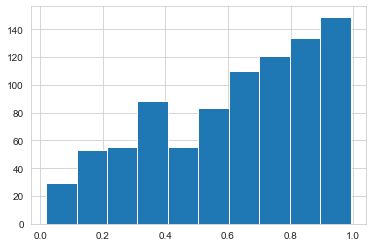

In [22]:
plt.hist(mdl.predict( X_whole[pos_index,:,:]));

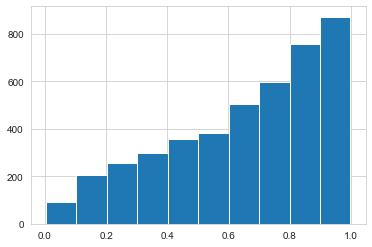

In [23]:
plt.hist(mdl.predict( X_whole[neg_index,:,:]));

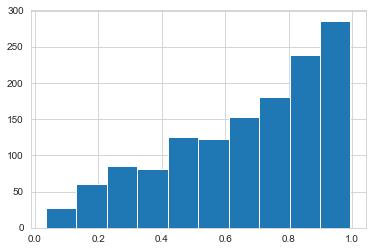

In [24]:
plt.hist(mdl.predict( X_whole[nbc_index,:,:]));

In [34]:
x = X_whole[pos_index,0,:]
X_new = np.repeat(x[:, np.newaxis, :], 72, axis=1)
y_pos = mdl.predict(X_new)
x = X_whole[neg_index,0,:]
X_new = np.repeat(x[:, np.newaxis, :], 72, axis=1)
y_neg = mdl.predict(X_new)
x = X_whole[nbc_index,0,:]
X_new = np.repeat(x[:, np.newaxis, :], 72, axis=1)
y_nbc = mdl.predict(X_new)

for i in range(1,X_whole.shape[1]):
    print("-------------------")
    # postive
    x = X_whole[pos_index,i,:]
    X_new = np.repeat(x[:, np.newaxis, :], 72, axis=1)
    y = mdl.predict(X_new)
    basemean = np.mean(Y_whole[:,0])
    print("predicted mean {}, basemean {}, relative risk {}".format(np.mean(y), basemean, np.mean(y)/basemean))
    y_pos = np.column_stack((y_pos,y))
    # negative
    x = X_whole[neg_index,i,:]
    X_new = np.repeat(x[:, np.newaxis, :], 72, axis=1)
    y = mdl.predict(X_new)
    basemean = np.mean(1-Y_whole[:,1])
    print("predicted mean {}, basemean {}, relative risk {}".format(np.mean(1-y), basemean, np.mean(1-y)/basemean))
    y_neg = np.column_stack((y_neg,y))
    # no blood culture
    x = X_whole[nbc_index,i,:]
    X_new = np.repeat(x[:, np.newaxis, :], 72, axis=1)
    y = mdl.predict(X_new)
    basemean = np.mean(1-Y_whole[:,2])
    print("predicted mean {}, basemean {}, relative risk {}".format(np.mean(1-y), basemean, np.mean(1-y)/basemean))
    y_nbc = np.column_stack((y_nbc,y))

-------------------
predicted mean 0.6868693232536316, basemean 0.13375019063596158, relative risk 5.135464256070766
predicted mean 0.20216992497444153, basemean 0.3413146255909715, relative risk 0.5923271662454929
predicted mean 0.21069438755512238, basemean 0.7924355650449901, relative risk 0.26588204372573854
-------------------
predicted mean 0.6835600733757019, basemean 0.13375019063596158, relative risk 5.110722236173862
predicted mean 0.20189565420150757, basemean 0.3413146255909715, relative risk 0.5915235945483848
predicted mean 0.20645488798618317, basemean 0.7924355650449901, relative risk 0.26053208247217147
-------------------
predicted mean 0.6844802498817444, basemean 0.13375019063596158, relative risk 5.117602050712198
predicted mean 0.20040695369243622, basemean 0.3413146255909715, relative risk 0.5871619282222093
predicted mean 0.20789897441864014, basemean 0.7924355650449901, relative risk 0.2623544217211361
-------------------
predicted mean 0.6820235252380371, base

predicted mean 0.3062867224216461, basemean 0.3413146255909715, relative risk 0.8973735652005065
predicted mean 0.32442760467529297, basemean 0.7924355650449901, relative risk 0.4094056589407036
-------------------
predicted mean 0.631060779094696, basemean 0.13375019063596158, relative risk 4.718204707552932
predicted mean 0.32718101143836975, basemean 0.3413146255909715, relative risk 0.9585906577307375
predicted mean 0.32141104340553284, basemean 0.7924355650449901, relative risk 0.40559896297345627
-------------------
predicted mean 0.6177211403846741, basemean 0.13375019063596158, relative risk 4.618469233183931
predicted mean 0.34054988622665405, basemean 0.3413146255909715, relative risk 0.997759429842793
predicted mean 0.31981417536735535, basemean 0.7924355650449901, relative risk 0.40358382368817336
-------------------
predicted mean 0.6224433183670044, basemean 0.13375019063596158, relative risk 4.653775186468013
predicted mean 0.33970528841018677, basemean 0.341314625590971

predicted mean 0.3524194657802582, basemean 0.7924355650449901, relative risk 0.4447294913628085
-------------------
predicted mean 0.6021213531494141, basemean 0.13375019063596158, relative risk 4.501835476169564
predicted mean 0.3687407970428467, basemean 0.3413146255909715, relative risk 1.080354515732773
predicted mean 0.35214290022850037, basemean 0.7924355650449901, relative risk 0.4443804843722627
-------------------
predicted mean 0.6049824357032776, basemean 0.13375019063596158, relative risk 4.52322671711105
predicted mean 0.3671259582042694, basemean 0.3413146255909715, relative risk 1.0756232832642514
predicted mean 0.3464893698692322, basemean 0.7924355650449901, relative risk 0.4372461120539945
-------------------
predicted mean 0.608855128288269, basemean 0.13375019063596158, relative risk 4.552181386757332
predicted mean 0.3686075210571289, basemean 0.3413146255909715, relative risk 1.0799640373420887
predicted mean 0.35065850615501404, basemean 0.7924355650449901, rela

In [32]:
df_pos = pd.DataFrame(data={'y_prob': y_pos.reshape([-1]), 'time': list(range(-48,24))*y_pos.shape[0]})
df_pos['y_true'] = 'positive'
df_pos['risk'] = df_pos['y_prob']/np.mean(Y_whole[:,0])
print(df_pos.head(5))
print(df_pos.shape)
df_neg = pd.DataFrame(data={'y_prob': y_neg.reshape([-1]), 'time': list(range(-48,24))*y_neg.shape[0]})
df_neg['y_true'] = 'negative'
df_neg['risk'] = (1-df_neg['y_prob'])/np.mean(1-Y_whole[:,1])
print(df_neg.head(5))
print(df_neg.shape)
df_nbc = pd.DataFrame(data={'y_prob': y_nbc.reshape([-1]), 'time': list(range(-48,24))*y_nbc.shape[0]})
df_nbc['y_true'] = 'baseline'
df_nbc['risk'] = (1-df_nbc['y_prob'])/np.mean(1-Y_whole[:,2])
print(df_nbc.head(5))
print(df_nbc.shape)
df_res = pd.concat([df_pos,df_neg,df_nbc], axis=0)
df_res.to_csv("./tte_plot_3class.csv", index=False)

     y_prob  time    y_true      risk
0  0.863392   -48  positive  6.455257
1  0.859521   -47  positive  6.426315
2  0.862688   -46  positive  6.449992
3  0.863174   -45  positive  6.453628
4  0.862604   -44  positive  6.449370
(63144, 4)
     y_prob  time    y_true      risk
0  0.868440   -48  negative  0.385450
1  0.864703   -47  negative  0.396401
2  0.867793   -46  negative  0.387346
3  0.868465   -45  negative  0.385378
4  0.868297   -44  negative  0.385871
(310968, 4)
     y_prob  time    y_true      risk
0  0.862071   -48  baseline  0.174058
1  0.858172   -47  baseline  0.178977
2  0.861345   -46  baseline  0.174973
3  0.861797   -45  baseline  0.174403
4  0.861139   -44  baseline  0.175233
(97992, 4)


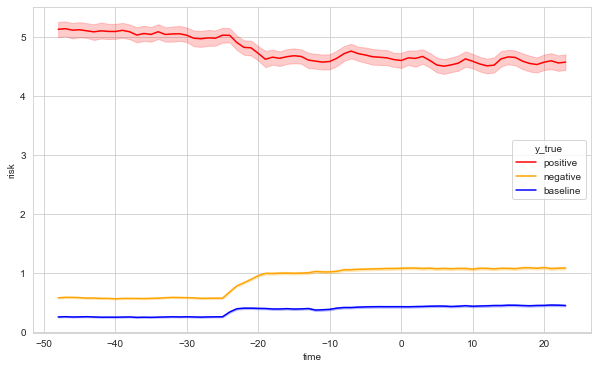

In [33]:
df_res = pd.read_csv("./tte_plot_3class.csv")
plt.figure(figsize=(10,6))
sns.lineplot(data=df_res, x="time", y="risk", hue="y_true", palette=['red','orange', 'blue']);

# binary raw scale

In [35]:
train_df = pd.read_csv("./train_df.csv")
valid_df = pd.read_csv("./valid_df.csv")
whole_df = pd.concat([train_df, valid_df], axis=0)
# median imputation
train_df.fillna(whole_df.median(), inplace=True)
valid_df.fillna(whole_df.median(), inplace=True)
whole_df.fillna(whole_df.median(), inplace=True)

In [36]:
input_vars = ['txp___yes', 'age___vital', 'temp___vital', 'heart_rate___vital', 'resp_rate___vital', 'spo2___vital', 'x_hr_rr___vital', 's_hr___vital', 's_rr___vital', 's_so2___vital', 'systolic_blood_pressure___vital', 'diastolic_blood_pressure___vital', 'glucose___vital', 'bilirubin___vital', 'potassium___vital', 'albumin___vital', 'calcium___vital', 'sodium___vital', 'wbc___vital', 'phosphorus___vital', 'creatinine___vital', 'platelet_count___vital', 'alt___vital', 'alp___vital', 'ast___vital', 'pco2___vital', 'chloride___vital', 'troponin___vital', 'ptt___vital', 'lactate___vital', 'bun___vital', 'magnesium___vital']
output_var = ['y___pos']

# reformat inputs to be 2d image and 1 output per image
X_whole = whole_df[input_vars].values
Y_whole = whole_df[output_var].values
X_whole = np.reshape(X_whole, (-1,72,32) )
Y_whole = np.reshape(Y_whole, (-1,72,1) )[:,0,:]
print(X_whole.shape)
print(Y_whole.shape)

# reformat inputs to be 2d image and 1 output per image
X_train = train_df[input_vars].values
Y_train = train_df[output_var].values
X_train = np.reshape(X_train, (-1,72,32) )
Y_train = np.reshape(Y_train, (-1,72,1) )[:,0,:]
print(X_train.shape)
print(Y_train.shape)

# reformat inputs to be 2d image and 1 output per image
X_valid = valid_df[input_vars].values
Y_valid = valid_df[output_var].values
X_valid = np.reshape(X_valid, (-1,72,32) )
Y_valid = np.reshape(Y_valid, (-1,72,1) )[:,0,:]
print(X_valid.shape)
print(Y_valid.shape)


(6557, 72, 32)
(6557, 1)
(5226, 72, 32)
(5226, 1)
(1331, 72, 32)
(1331, 1)


In [37]:
myMetrics = [
    keras.metrics.AUC(name='AUROC', curve='ROC'),
    keras.metrics.AUC(name='AUPRC', curve='PR')
]

keras.backend.clear_session()
mdl = keras.models.Sequential([
    keras.layers.LSTM(32, return_sequences=True, input_shape=list(X_train.shape)[1:4]),
    keras.layers.BatchNormalization(),
    keras.layers.LSTM(32, return_sequences=False),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(1, activation='sigmoid')
])
mdl.summary()
mdl.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=1e-3), metrics = myMetrics)
callback = EarlyStopping(monitor='val_loss', patience=10)
his = mdl.fit(X_train, Y_train, 
              epochs=50, 
              validation_data=(X_valid,Y_valid), callbacks=[callback])
keras.backend.set_value(mdl.optimizer.learning_rate, 1e-4)
his = mdl.fit(X_train, Y_train, 
              epochs=50, 
              validation_data=(X_valid,Y_valid), callbacks=[callback])
keras.backend.set_value(mdl.optimizer.learning_rate, 1e-5)
his = mdl.fit(X_train, Y_train, 
              epochs=50, 
              validation_data=(X_valid,Y_valid), callbacks=[callback])
keras.backend.set_value(mdl.optimizer.learning_rate, 1e-6)
his = mdl.fit(X_train, Y_train, 
              epochs=50, 
              validation_data=(X_valid,Y_valid), callbacks=[callback])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 72, 32)            8320      
_________________________________________________________________
batch_normalization (BatchNo (None, 72, 32)            128       
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                128       
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 16,929
Trainable params: 16,801
Non-trainable params: 128
_________________________________________________________________
Epoch 1/50
164/164 [==============================] - 12s 52ms/step - loss: 0.7100 - AUROC: 0.5394 - AUPRC: 0.1543 -

In [80]:
train_df = pd.read_csv("./train_df.csv")
valid_df = pd.read_csv("./valid_df.csv")
whole_df = pd.concat([train_df, valid_df], axis=0)

# fill na by within group median
pos_df = whole_df.loc[whole_df['y___pos']==1.0,:].copy()
pos_df.fillna(pos_df.median(), inplace=True)
neg_df = whole_df.loc[whole_df['y___neg']==1.0,:].copy()
neg_df.fillna(neg_df.median(), inplace=True)
nbc_df = whole_df.loc[whole_df['y___nbc']==1.0,:].copy()
nbc_df.fillna(nbc_df.median(), inplace=True)

whole_df.loc[whole_df['y___pos']==1.0,:] = pos_df
whole_df.loc[whole_df['y___neg']==1.0,:] = neg_df
whole_df.loc[whole_df['y___nbc']==1.0,:] = nbc_df

input_vars = ['txp___yes', 'age___vital', 'temp___vital', 'heart_rate___vital', 'resp_rate___vital', 'spo2___vital', 'x_hr_rr___vital', 's_hr___vital', 's_rr___vital', 's_so2___vital', 'systolic_blood_pressure___vital', 'diastolic_blood_pressure___vital', 'glucose___vital', 'bilirubin___vital', 'potassium___vital', 'albumin___vital', 'calcium___vital', 'sodium___vital', 'wbc___vital', 'phosphorus___vital', 'creatinine___vital', 'platelet_count___vital', 'alt___vital', 'alp___vital', 'ast___vital', 'pco2___vital', 'chloride___vital', 'troponin___vital', 'ptt___vital', 'lactate___vital', 'bun___vital', 'magnesium___vital']
output_var = ['y___pos']

# reformat inputs to be 2d image and 1 output per image
X_whole = whole_df[input_vars].values
Y_whole = whole_df[output_var].values
X_whole = np.reshape(X_whole, (-1,72,32) )
Y_whole = np.reshape(Y_whole, (-1,72,1) )[:,0,:]
print(X_whole.shape)
print(Y_whole.shape)

(6557, 72, 32)
(6557, 1)


In [82]:
# reformat outcome columns into 3 categories
output_var = ['y___pos','y___neg','y___nbc']


Y_whole = whole_df[output_var].values
Y_whole = np.reshape(Y_whole, (-1,72,3) )[:,0,:]
print(Y_whole.shape)


pos_index = np.where(Y_whole[:,0]==1.0)[0]
neg_index = np.where(Y_whole[:,1]==1.0)[0]
nbc_index = np.where(Y_whole[:,2]==1.0)[0]



x = X_whole[pos_index,0,:]
X_new = np.repeat(x[:, np.newaxis, :], 72, axis=1)
y_pos = mdl.predict(X_new)
x = X_whole[neg_index,0,:]
X_new = np.repeat(x[:, np.newaxis, :], 72, axis=1)
y_neg = mdl.predict(X_new)
x = X_whole[nbc_index,0,:]
X_new = np.repeat(x[:, np.newaxis, :], 72, axis=1)
y_nbc = mdl.predict(X_new)

for i in range(1,X_whole.shape[1]):
    print("-------------------")
    # postive
    x = X_whole[pos_index,i,:]
    X_new = np.repeat(x[:, np.newaxis, :], 72, axis=1)
    y = mdl.predict(X_new)
    basemean = np.mean(Y_whole[:,0])
    print("predicted mean {}, basemean {}, relative risk {}".format(np.mean(y), basemean, np.mean(y)/basemean))
    y_pos = np.column_stack((y_pos,y))
    # negative
    x = X_whole[neg_index,i,:]
    X_new = np.repeat(x[:, np.newaxis, :], 72, axis=1)
    y = mdl.predict(X_new)
    basemean = np.mean(1-Y_whole[:,1])
    print("predicted mean {}, basemean {}, relative risk {}".format(np.mean(1-y), basemean, np.mean(1-y)/basemean))
    y_neg = np.column_stack((y_neg,y))
    # no blood culture
    x = X_whole[nbc_index,i,:]
    X_new = np.repeat(x[:, np.newaxis, :], 72, axis=1)
    y = mdl.predict(X_new)
    basemean = np.mean(1-Y_whole[:,2])
    print("predicted mean {}, basemean {}, relative risk {}".format(np.mean(1-y), basemean, np.mean(1-y)/basemean))
    y_nbc = np.column_stack((y_nbc,y))

(6557, 3)
-------------------
predicted mean 0.41208890080451965, basemean 0.13375019063596158, relative risk 3.0810341192420014
predicted mean 0.9337747693061829, basemean 0.3413146255909715, relative risk 2.7358182137357647
predicted mean 0.923815131187439, basemean 0.7924355650449901, relative risk 1.1657921122394221
-------------------
predicted mean 0.41267016530036926, basemean 0.13375019063596158, relative risk 3.0853800158204345
predicted mean 0.9337407946586609, basemean 0.3413146255909715, relative risk 2.7357186731799996
predicted mean 0.924470841884613, basemean 0.7924355650449901, relative risk 1.1666195747185157
-------------------
predicted mean 0.41217347979545593, basemean 0.13375019063596158, relative risk 3.0816664846280553
predicted mean 0.933950662612915, basemean 0.3413146255909715, relative risk 2.7363335544025396
predicted mean 0.9240179061889648, basemean 0.7924355650449901, relative risk 1.166048000554473
-------------------
predicted mean 0.4110882580280304, 

predicted mean 0.81401127576828, basemean 0.3413146255909715, relative risk 2.384929372302329
predicted mean 0.7319506406784058, basemean 0.7924355650449901, relative risk 0.9236721229654169
-------------------
predicted mean 0.447384238243103, basemean 0.13375019063596158, relative risk 3.344924116488057
predicted mean 0.7489262223243713, basemean 0.3413146255909715, relative risk 2.1942400535214044
predicted mean 0.7187636494636536, basemean 0.7924355650449901, relative risk 0.9070310333974549
-------------------
predicted mean 0.46133145689964294, basemean 0.13375019063596158, relative risk 3.4492022381880942
predicted mean 0.6669188737869263, basemean 0.3413146255909715, relative risk 1.9539709809744752
predicted mean 0.7120497822761536, basemean 0.7924355650449901, relative risk 0.8985585878338604
-------------------
predicted mean 0.47029978036880493, basemean 0.13375019063596158, relative risk 3.51625502836745
predicted mean 0.6306047439575195, basemean 0.3413146255909715, relat

predicted mean 0.49149787425994873, basemean 0.13375019063596158, relative risk 3.67474522408493
predicted mean 0.6041426062583923, basemean 0.3413146255909715, relative risk 1.7700460541717062
predicted mean 0.6590443253517151, basemean 0.7924355650449901, relative risk 0.8316692920190908
-------------------
predicted mean 0.49363258481025696, basemean 0.13375019063596158, relative risk 3.690705654048865
predicted mean 0.602493166923523, basemean 0.3413146255909715, relative risk 1.7652134475056032
predicted mean 0.6581664681434631, basemean 0.7924355650449901, relative risk 0.8305614956922032
-------------------
predicted mean 0.49520131945610046, basemean 0.13375019063596158, relative risk 3.702434494496751
predicted mean 0.6014642715454102, basemean 0.3413146255909715, relative risk 1.7621989403589162
predicted mean 0.6572375297546387, basemean 0.7924355650449901, relative risk 0.829389238375898
-------------------
predicted mean 0.4984905421733856, basemean 0.13375019063596158, re

In [83]:
df_pos = pd.DataFrame(data={'y_prob': y_pos.reshape([-1]), 'time': list(range(-48,24))*y_pos.shape[0]})
df_pos['y_true'] = 'positive'
df_pos['risk'] = df_pos['y_prob']/np.mean(Y_whole[:,0])
print(df_pos.head(5))
print(df_pos.shape)
df_neg = pd.DataFrame(data={'y_prob': y_neg.reshape([-1]), 'time': list(range(-48,24))*y_neg.shape[0]})
df_neg['y_true'] = 'negative'
df_neg['risk'] = (1-df_neg['y_prob'])/np.mean(1-Y_whole[:,1])
print(df_neg.head(5))
print(df_neg.shape)
df_nbc = pd.DataFrame(data={'y_prob': y_nbc.reshape([-1]), 'time': list(range(-48,24))*y_nbc.shape[0]})
df_nbc['y_true'] = 'baseline'
df_nbc['risk'] = (1-df_nbc['y_prob'])/np.mean(1-Y_whole[:,2])
print(df_nbc.head(5))
print(df_nbc.shape)
df_res = pd.concat([df_pos,df_neg,df_nbc], axis=0)
df_res.to_csv("./tte_plot_3class_raw.csv", index=False)

     y_prob  time    y_true      risk
0  0.336653   -48  positive  2.517027
1  0.336653   -47  positive  2.517027
2  0.336653   -46  positive  2.517027
3  0.336653   -45  positive  2.517027
4  0.336653   -44  positive  2.517027
(63144, 4)
     y_prob  time    y_true      risk
0  0.034173   -48  negative  2.829726
1  0.034173   -47  negative  2.829726
2  0.034173   -46  negative  2.829726
3  0.034173   -45  negative  2.829726
4  0.034173   -44  negative  2.829726
(310968, 4)
     y_prob  time    y_true      risk
0  0.032376   -48  baseline  1.221076
1  0.032376   -47  baseline  1.221076
2  0.032376   -46  baseline  1.221076
3  0.032376   -45  baseline  1.221076
4  0.032376   -44  baseline  1.221076
(97992, 4)


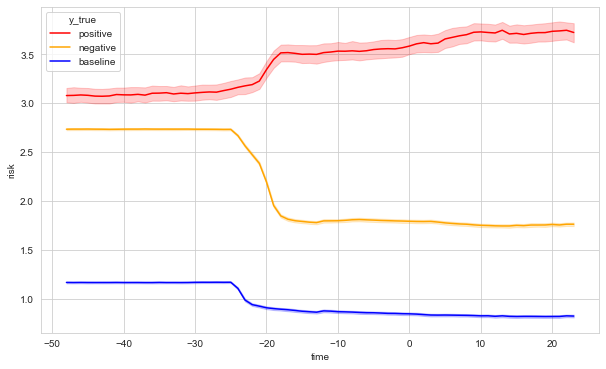

In [84]:
df_res = pd.read_csv("./tte_plot_3class_raw.csv")
plt.figure(figsize=(10,6))
sns.lineplot(data=df_res, x="time", y="risk", hue="y_true", palette=['red','orange', 'blue']);

# performance over time

In [85]:
train_df = pd.read_csv("./train_df.csv")
valid_df = pd.read_csv("./valid_df.csv")
whole_df = pd.concat([train_df, valid_df], axis=0)
# median imputation
train_df.fillna(whole_df.median(), inplace=True)
valid_df.fillna(whole_df.median(), inplace=True)
whole_df.fillna(whole_df.median(), inplace=True)

input_vars = ['txp___yes', 'age___vital', 'temp___vital', 'heart_rate___vital', 'resp_rate___vital', 'spo2___vital', 'x_hr_rr___vital', 's_hr___vital', 's_rr___vital', 's_so2___vital', 'systolic_blood_pressure___vital', 'diastolic_blood_pressure___vital', 'glucose___vital', 'bilirubin___vital', 'potassium___vital', 'albumin___vital', 'calcium___vital', 'sodium___vital', 'wbc___vital', 'phosphorus___vital', 'creatinine___vital', 'platelet_count___vital', 'alt___vital', 'alp___vital', 'ast___vital', 'pco2___vital', 'chloride___vital', 'troponin___vital', 'ptt___vital', 'lactate___vital', 'bun___vital', 'magnesium___vital']
output_var = ['y___pos']

# reformat inputs to be 2d image and 1 output per image
X_whole = whole_df[input_vars].values
Y_whole = whole_df[output_var].values
X_whole = np.reshape(X_whole, (-1,72,32) )
Y_whole = np.reshape(Y_whole, (-1,72,1) )[:,0,:]
print(X_whole.shape)
print(Y_whole.shape)


(6557, 72, 32)
(6557, 1)


In [90]:


score_list = list()
y_true = Y_whole[:,0]
x = X_whole[:,0,:]
X_new = np.repeat(x[:, np.newaxis, :], 72, axis=1)
y_pred = mdl.predict(X_new)
score = sklearn.metrics.roc_auc_score(y_true, y_pred)
score_list.append(score)

for i in range(1,X_whole.shape[1]):
    print("-------------------")
    # postive
    x = X_whole[:,i,:]
    X_new = np.repeat(x[:, np.newaxis, :], 72, axis=1)
    y_pred = mdl.predict(X_new)
    score=sklearn.metrics.roc_auc_score(y_true, y_pred)
    score_list.append(score)

    

-------------------
-------------------
-------------------
-------------------
-------------------
-------------------
-------------------
-------------------
-------------------
-------------------
-------------------
-------------------
-------------------
-------------------
-------------------
-------------------
-------------------
-------------------
-------------------
-------------------
-------------------
-------------------
-------------------
-------------------
-------------------
-------------------
-------------------
-------------------
-------------------
-------------------
-------------------
-------------------
-------------------
-------------------
-------------------
-------------------
-------------------
-------------------
-------------------
-------------------
-------------------
-------------------
-------------------
-------------------
-------------------
-------------------
-------------------
-------------------
-------------------
-------------------


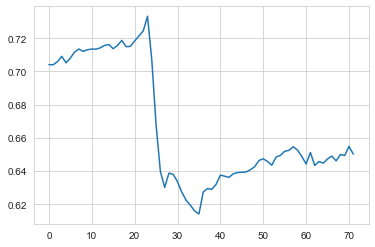

In [93]:
plt.plot(score_list)

In [94]:
df_res = pd.read_csv("./tte_plot.csv")

In [96]:
df_res['y'] = 0
df_res.loc[df_res['y_true']=='event','y'] = 1
df_res

,y_prob,time,y_true,risk,y
0,0.005454,-48,event,0.040777,1
1,0.005454,-47,event,0.040777,1
2,0.005454,-46,event,0.040777,1
3,0.005454,-45,event,0.040777,1
4,0.005454,-44,event,0.040777,1
...,...,...,...,...,...
472099,0.517914,19,control,3.872245,0
472100,0.479352,20,control,3.583938,0
472101,0.442411,21,control,3.307738,0
472102,0.494195,22,control,3.694911,0


In [97]:
score_list = list()
for i in range(-48,24,1):
    y_true = df_res.loc[df_res['time']==i, 'y']
    y_pred = df_res.loc[df_res['time']==i, 'y_prob']
    score=sklearn.metrics.roc_auc_score(y_true, y_pred)
    score_list.append(score)

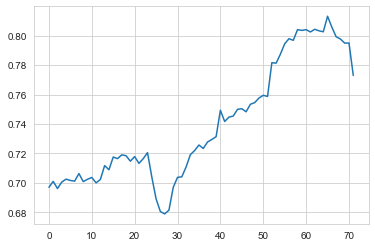

In [99]:
plt.plot(score_list)